# `순열` 설명자

이 노트북은 몇 가지 간단한 데이터 집합에서 순열 설명자를 사용하는 방법을 보여드립니다. 순열 설명기는 모델에 구애받지 않으므로 모든 모델에 대해 샤플리 값과 오웬 값을 계산할 수 있습니다. 순방향 및 역방향 피처의 완전한 순열을 반복하는 방식으로 작동합니다. 이렇게 한 번에 하나의 특징을 변경하면 필요한 모델 평가 횟수를 최소화할 수 있으며, 특징 어트리뷰션 값을 추정하는 데 사용하기로 선택한 원래 모델을 몇 번 실행하더라도 항상 효율성을 충족할 수 있습니다. 따라서 계산된 SHAP 값은 근사치이기는 하지만 설명된 각 인스턴스에 대한 모델의 기본 값과 모델의 출력 간의 차이를 정확히 합산합니다.

순열 설명자는 중요한 성능 최적화 기능이 있고 커널 설명자처럼 정규화 매개변수 조정이 필요하지 않기 때문에, 순열 설명자는 정확한 설명자에 적합한 것보다 더 많은 기능이 있는 표 형식 데이터 집합에 사용되는 기본 모델 불가지론적 설명자입니다.

아래에서는 간단한 성인 소득 분류 데이터 집합 및 모델에서 순열 설명자를 사용하는 방법을 설명합니다.

In [1]:
import shap
import xgboost

# 소득 예측에 대한 데이터 세트 가져오기
X,y = shap.datasets.adult()

# XGBoost 모델을 훈련합니다(다른 모델 유형도 작동 가능).
model = xgboost.XGBClassifier()
model.fit(X, y);

## 독립(샤플리 값) 마스킹이 적용된 테이블 형식 데이터

In [2]:
# 순열 설명자를 구축하고 주어진 데이터 세트에 대한 모델 예측을 설명합니다.
explainer = shap.explainers.Permutation(model.predict_proba, X)
shap_values = explainer(X[:100])

# 긍정적 인 클래스에 대한 설명 만 얻으십시오.
shap_values = shap_values[...,1]

### 전역 요약 플롯

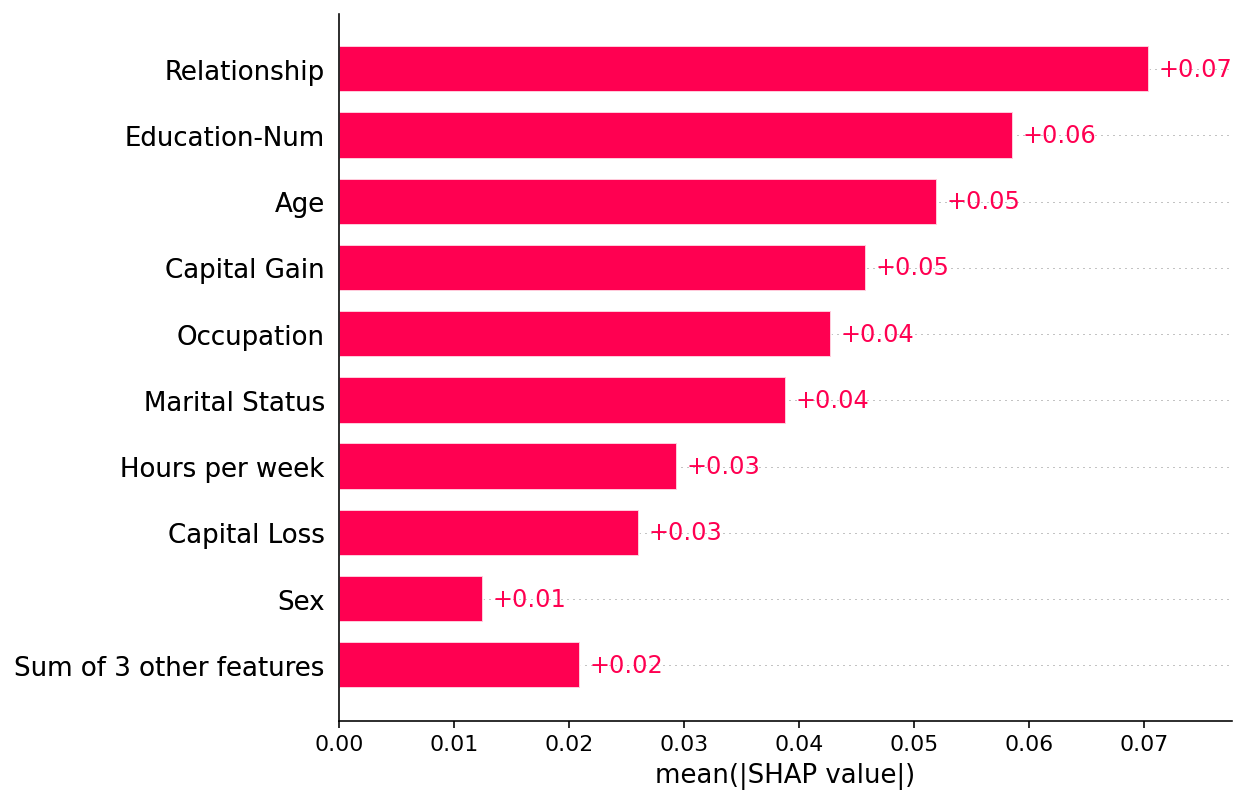

In [3]:
shap.plots.bar(shap_values)

### 단일 인스턴스 플롯

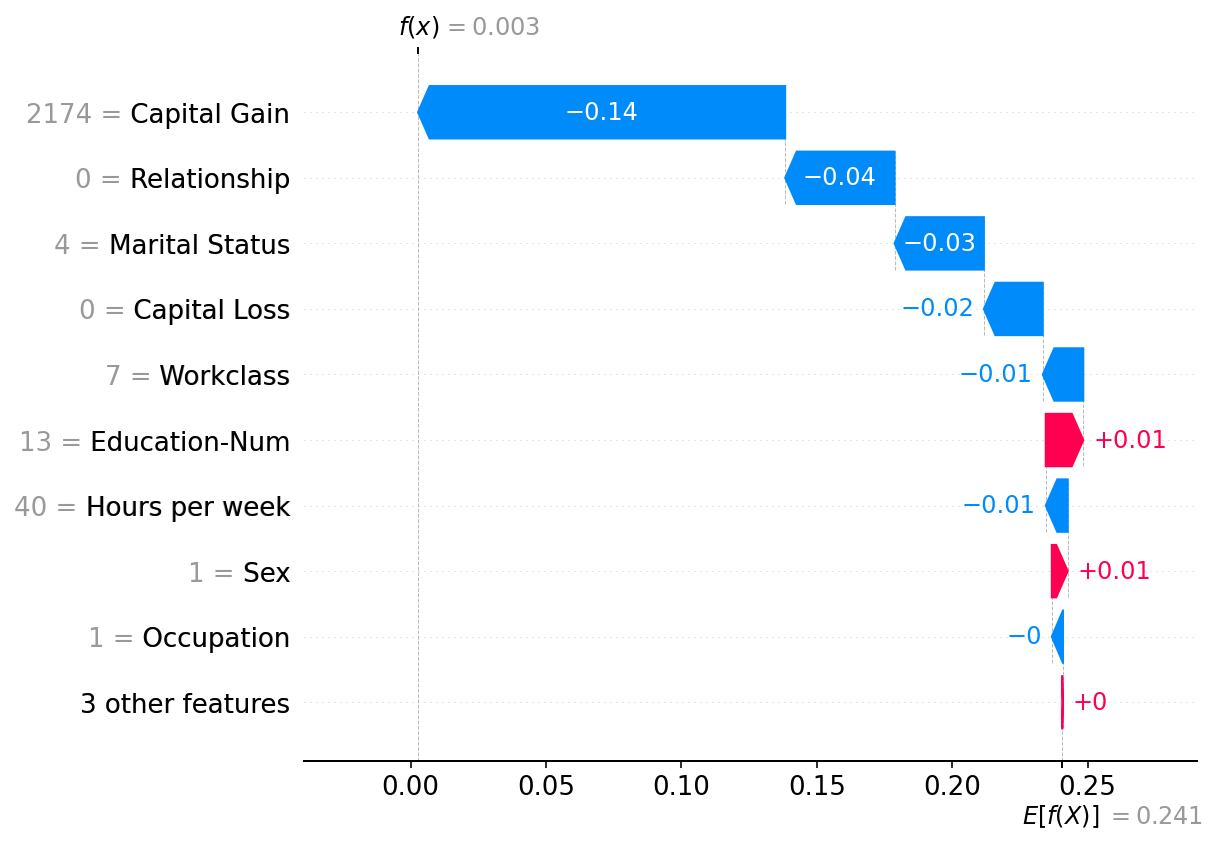

In [4]:
shap.plots.waterfall(shap_values[0])

## 파티션(오웬 값) 마스킹이 있는 테이블형 데이터

샤플리 값은 각 특징을 다른 특징과 독립적으로 처리한 결과이지만, 모델 입력에 구조를 적용하는 것이 유용할 때가 많습니다. 이러한 구조를 적용하면 구조 게임(즉, 유효한 입력 특징 연합에 대한 규칙이 있는 게임)이 생성되며, 해당 구조가 특징 그룹화의 중첩 집합인 경우 그룹에 샤플리 값을 재귀적으로 적용하여 오웬 값을 얻게 됩니다. SHAP에서는 파티셔닝을 한계까지 확장하여 데이터의 구조를 나타내는 이진 계층적 클러스터링 트리를 구축합니다. 이 구조는 여러 가지 방법으로 선택할 수 있지만, 표 형식 데이터의 경우 출력 레이블에 대한 입력 특징 간의 중복 정보로부터 구조를 구축하는 것이 도움이 되는 경우가 많습니다. 이것이 바로 아래에서 수행하는 작업입니다:

In [3]:
#  y 에 대한 공유 정보를 기반으로 특징의 클러스터링을 구축합니다.
clustering = shap.utils.hclust(X, y)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [7]:
# 위에서는 원시 데이터 프레임을 마스커로 전달하여 암시적으로 shap.maskers.Independent를 사용했지만, 
# 이제는 방금 계산한 클러스터링을 사용하는 Partition 마스커를 명시적으로 사용합니다.
masker = shap.maskers.Partition(X, clustering=clustering)

# 순열 설명자를 구축하고 주어진 데이터 세트에 대한 모델 예측을 설명합니다.
explainer = shap.explainers.Permutation(model.predict_proba, masker)
shap_values2 = explainer(X[:100])

# 긍정적 인 클래스에 대한 설명 만 얻으십시오.
shap_values2 = shap_values2[...,1]

### 전역 요약 플롯

관계 및 결혼 상태 특징만 서로 50% 이상의 설명력(R2로 측정)을 공유하므로 클러스터링 트리의 다른 모든 부분은 기본 `클러스터링_컷오프=0.5` 설정에 의해 제거됩니다:

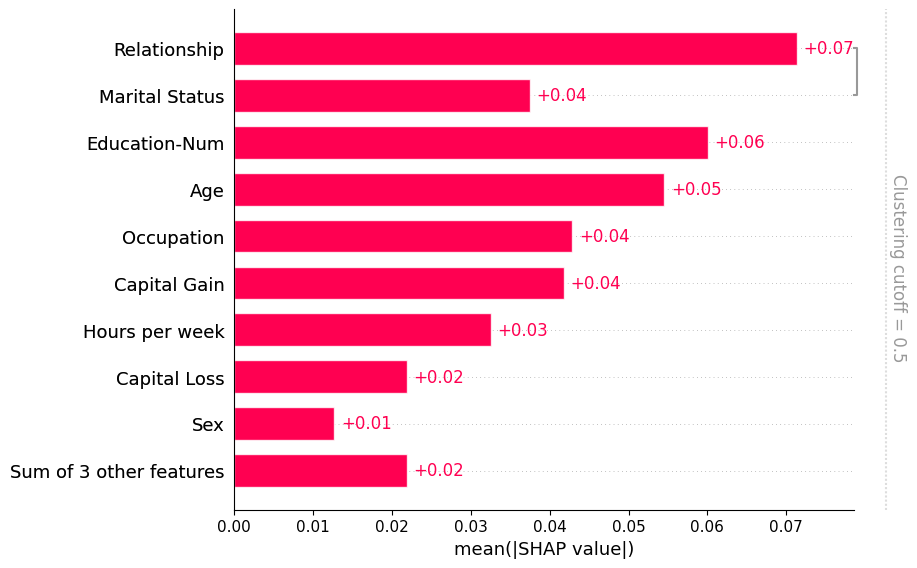

In [8]:
shap.plots.bar(shap_values2)

### 단일 인스턴스 플롯

위의 독립 마스커 설명과 여기서의 파티션 마스커 설명 사이에는 매우 유사하다는 점에 유의하십시오. 일반적으로 표 형식 데이터에 대한 이 두 방법의 차이는 크지 않지만, 파티션 마스커를 사용하면 클러스터된 특징 그룹이 함께 마스킹/마스킹 해제되므로 런타임이 훨씬 빠르고 모델 입력을 더 사실적으로 조작할 수 있습니다.

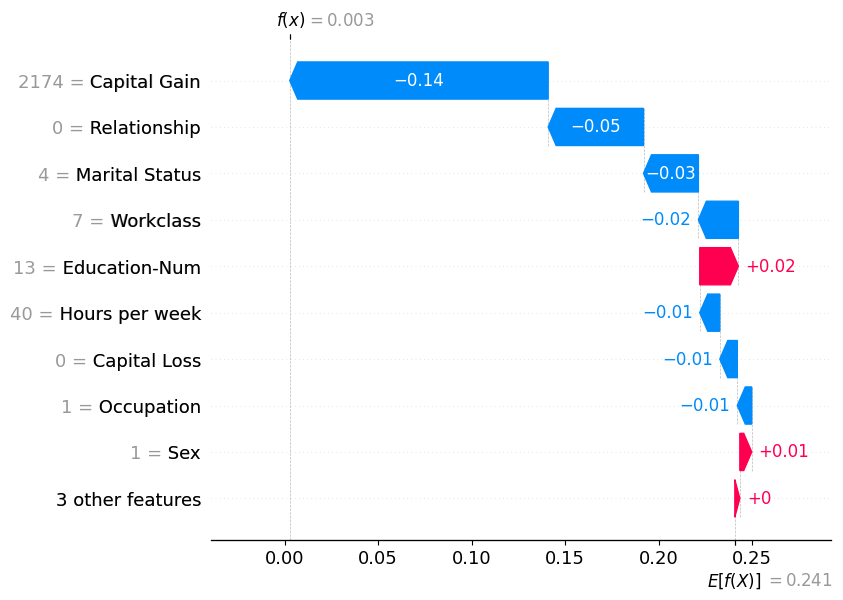

In [9]:
shap.plots.waterfall(shap_values2[0])

<hr>
Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged! 